In [1]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from cycler import cycler
import geoplot as gplt
import geoplot.crs as gcrs

import ee
import rasterio
from rasterio.plot import show as showRasterio
from EarthEngineToGeoTIFF import getSentinalS2SRImage, getPlanetSkySat, getNAIPImage

# ee.Authenticate() # Trigger the authentication flow.

ee.Initialize() # Initialize the library.

In [2]:
tower_loc = [41.701827, -87.996285]
r_earth = 6378137.0 # approx radius of earth in m
meters_per_lon = (np.pi/180) * r_earth * np.cos(tower_loc[0]*np.pi/180)

In [3]:
lat = tower_loc[0]
lon = tower_loc[1]
sze = 0.01 # size of image in degrees
filename = f'ATMOS_NAIP_{sze}.tif'

dateMin = '2019-01-01'
dateMax = '2020-12-31'
vmin = 0
vmax = 3500

_ = getNAIPImage(lon, lat, sze, filename)

Creating 3-band GeoTIFF image ... 


In [6]:
# define the area of interest, using the Earth Engines geometry object
coords = [
     [lon - sze/2., lat - sze/2.],
     [lon + sze/2., lat - sze/2.],
     [lon + sze/2., lat + sze/2.],
     [lon - sze/2., lat + sze/2.],
     [lon - sze/2., lat - sze/2.]
]
aoi = ee.Geometry.Polygon(coords)

In [7]:
db = ee.Image(ee.ImageCollection('USDA/NAIP/DOQQ')
             .filterBounds(aoi)
             .filterDate(ee.Date(dateMin), ee.Date(dateMax))
              .first())
db

In [16]:
# # get the image using Google's Earth Engine
# db = ee.Image(ee.ImageCollection('SKYSAT/GEN-A/PUBLIC/ORTHO/RGB')\
#                    .filterBounds(aoi)\
#                    .filterDate(ee.Date(dateMin), ee.Date(dateMax))\
# #                       .sort('CLOUDY_PIXEL_PERCENTAGE')\
#                    .first())

# db = ee.Image(ee.ImageCollection('SKYSAT/GEN-A/PUBLIC/ORTHO/RGB'))
db = ee.Image(ee.ImageCollection("SKYSAT/GEN-A/PUBLIC/ORTHO/RGB"))


In [79]:
db = ee.Image(ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(aoi).filterDate(ee.Date(dateMin), ee.Date(dateMax)).first())
ee.Image.bandNames(db).get(0)

In [54]:
print(ee.ImageCollection("SKYSAT/GEN-A/PUBLIC/ORTHO/RGB")
      .filterBounds(aoi).first().bandNames())

ee.List({
  "functionInvocationValue": {
    "functionName": "Image.bandNames",
    "arguments": {
      "image": {
        "functionInvocationValue": {
          "functionName": "Collection.first",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "Collection.filter",
                "arguments": {
                  "collection": {
                    "functionInvocationValue": {
                      "functionName": "ImageCollection.load",
                      "arguments": {
                        "id": {
                          "constantValue": "SKYSAT/GEN-A/PUBLIC/ORTHO/RGB"
                        }
                      }
                    }
                  },
                  "filter": {
                    "functionInvocationValue": {
                      "functionName": "Filter.intersects",
                      "arguments": {
                        "leftField": {
                         

In [ ]:
db = (ee.ImageCollection("SKYSAT/GEN-A/PUBLIC/ORTHO/RGB")
      .filterBounds(aoi)
#       .filterDate(ee.Date(dateMin), ee.Date(dateMax))
      .first())
db

In [8]:
# add the latitude and longitude
db = db.addBands(ee.Image.pixelLonLat())

# define the bands that I want to use.  R is red, G is green, B is blue
# https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR#bands
bands = ['R', 'G', 'B']

task = ee.batch.Export.image.toDrive(image=db.select(bands[0]),
                                    description=bands[0],
                                    scale=30,
                                    region=aoi,
                                    fileNamePrefix=bands[0],
                                    crs='EPSG:4326',
                                    fileFormat='GeoTIFF')
task.start()

# url = db.select(bands[0]).getDownloadURL()

In [9]:
url = db.select(bands[0]).getDownloadURL({
    'scale': 30,
    'crs': 'EPSG:4326',
    'fileFormat': 'GeoTIFF',
    'region': aoi
})

In [82]:
bandname = ee.String(db.bandNames().get(0))

In [ ]:
# export geotiff images, these go to Drive and then are downloaded locally
for selection in bands:
    task = ee.batch.Export.image.toDrive(image=db.select(selection),
                                 description=selection,
                                 scale=30,
                                 region=aoi,
                                 fileNamePrefix=selection,
                                 crs='EPSG:4326',
                                 fileFormat='GeoTIFF')
    task.start()

    url = db.select(selection).getDownloadURL({
        'scale': 30,
        'crs': 'EPSG:4326',
        'fileFormat': 'GeoTIFF',
        'region': aoi})

    r = requests.get(url, stream=True)

    filenameZip = selection+'.zip'
    filenameTif = selection+'.tif'

    # unzip and write the tif file, then remove the original zip file
    with open(filenameZip, "wb") as fd:
        for chunk in r.iter_content(chunk_size=1024):
            fd.write(chunk)

    zipdata = zipfile.ZipFile(filenameZip)
    zipinfos = zipdata.infolist()

    # iterate through each file (there should be only one)
    for zipinfo in zipinfos:
        zipinfo.filename = filenameTif
        zipdata.extract(zipinfo)

    zipdata.close()

# create a combined RGB geotiff image
# https://gis.stackexchange.com/questions/341809/merging-sentinel-2-rgb-bands-with-rasterio
print('Creating 3-band GeoTIFF image ... ')

# open the images
R = rasterio.open('R.tif')
G = rasterio.open('G.tif')
B = rasterio.open('B.tif')

# get the scaling
image = np.array([B.read(1), G.read(1), R.read(1)]).transpose(1,2,0)
p2, p98 = np.percentile(image, (2,98))

# use the B image as a starting point so that I keep the same parameters
B_geo = B.profile
B_geo.update({'count': 3})

with rasterio.open(filename, 'w', **B_geo) as dest:
    dest.write( (np.clip(R.read(1), p2, p98) - p2)/(p98 - p2)*255, 1)
    dest.write( (np.clip(G.read(1), p2, p98) - p2)/(p98 - p2)*255, 2)
    dest.write( (np.clip(B.read(1), p2, p98) - p2)/(p98 - p2)*255, 3)

B.close()
G.close()
R.close()

# remove the intermediate files
for selection in bands:
    os.remove(selection + '.tif')
    os.remove(selection + '.zip')

In [4]:
# tower latitude, longitude and approximate size of Sentinel-2 image to retrieve
sze = 0.02
_ = getPlanetSkySat(tower_loc[1], tower_loc[0], sze, f'ATMOSGeoTIFF_SkySat_{sze}.tif')

EEException: Image.addBands: Parameter 'dstImg' is required.

In [5]:
# tower latitude, longitude and approximate size of Sentinel-2 image to retrieve
sze = 0.02
_ = getSentinalS2SRImage(tower_loc[1], tower_loc[0], sze, f'ATMOSGeoTIFF_Sentinel2{sze}.tif')

Creating 3-band GeoTIFF image ... 


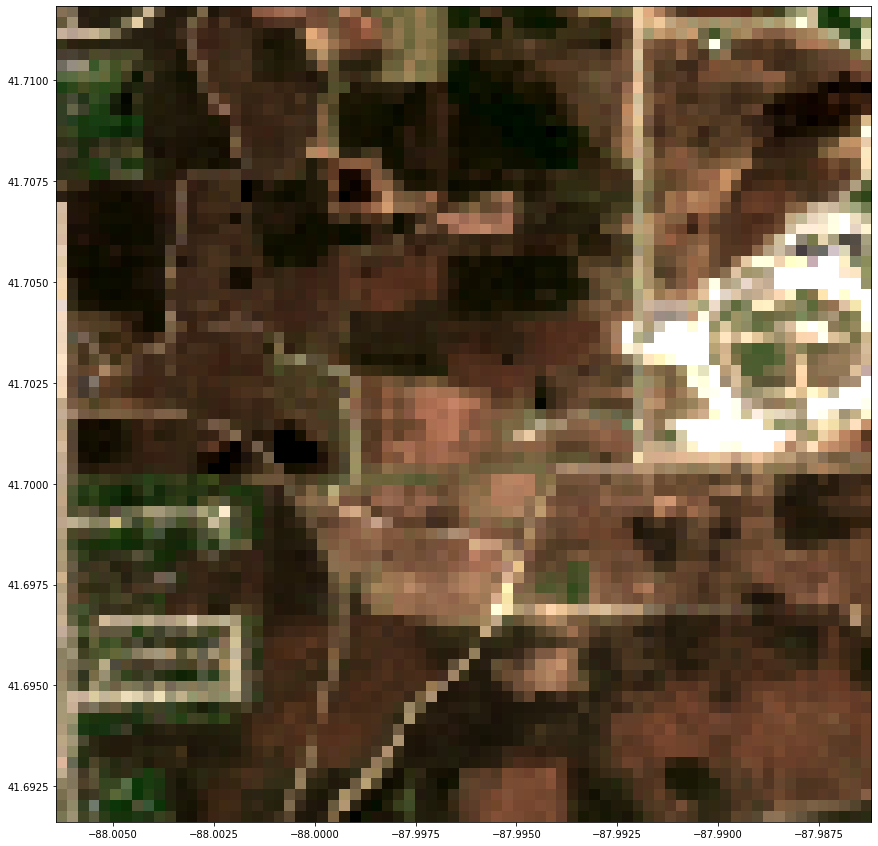

In [6]:
f,ax = plt.subplots(figsize=(15,15))

ATMOS = rasterio.open('ATMOSGeoTIFF_Sentinel20.02.tif')
showRasterio(ATMOS.read(), ax = ax, transform=ATMOS.transform)

ATMOS.close()